In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import model_selection
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import random
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from multiprocessing import Pool
from collections import Counter

def class_fun(feature,profile,group):#
    exp_pre=profile.loc[feature,:]
    #test_exp_pre=test_profile.loc[feature,]
    dat2=exp_pre.stack()
    exp=dat2.unstack(0)
    #dat3=test_exp_pre.stack()
    #test_exp=dat3.unstack(0)
    rf_new = RandomForestClassifier(class_weight="balanced")
    rf_new.fit(exp, group)
    #prediction = rf_new.predict(test_exp)
    #交叉验证，5次准确率
    scores = cross_val_score(rf_new, exp, group, cv=5,scoring='accuracy')
    #print(scores)
    accuracy_value=pd.DataFrame({'accuracy':scores})
    mean_acc=accuracy_value.loc[:,'accuracy'].mean()
    #print(mean_acc)
    #accuracy_selection.append(accuracy_score(prediction, test_group))
    #cvs_selection.append(np.mean(scores))
    ##train_roc
    y_score = rf_new.predict_proba(exp)[:,1]
    fpr,tpr,threshold = metrics.roc_curve(group, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    ##test_roc
    #y_score = rf_new.predict_proba(test_exp)[:,1]
    #fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
    #roc_auc_test = metrics.auc(fpr,tpr)
    
    #print(pred_y_rf_new)
    importance=rf_new.feature_importances_
    data = { 'gene' : feature, 'importance' :importance }
    df = pd.DataFrame(data)
    df.loc['ROC']=['ROC',roc_auc]
    #df.loc['ROC_test']=['ROC_test',roc_auc_test]
    df.loc['Mean_accuracy']=['Mean_accuracy',mean_acc]

    return df

def combination_fun(x,profile,group):
    #gene_all=[]
    all_value=pd.DataFrame({'gene_pair':[],'gene':[],'importance':[],'Rank':[],'roc':[],'module_two_genes':[],
                            'iteration1':[],'iteration2':[]})
    module=x.iloc[:,1].drop_duplicates().values.tolist()
    for mm in module: 
        print(mm)
        gene_module=x.loc[x['modeuleType'] != mm].gene.tolist()
        #print(gene_module)
        y=x[x.modeuleType.isin([mm])].gene
        for i in range(0,len(y)-1):
            for j in range(i+1,len(y)):
                gene=[y[i],y[j]]
                gene_all=gene_module+gene
                #print(gene_all)
                class_results=class_fun(gene_all,profile,group)#
                roc=class_results.loc['ROC'].importance
                #roc_test=class_results.loc['ROC_test'].importance
                mean_acc=class_results.loc['Mean_accuracy'].importance
                gene_importance=class_results.drop(index=["ROC","Mean_accuracy"])
                gene_importance['Rank'] = gene_importance['importance'].rank(method="average")

                #gene_all=gene_all.append(gene_importance)
                #roc_all.extend([roc])
                valuedf=pd.DataFrame({'gene_pair':'_'.join(gene),'gene':gene_importance.gene,'importance':gene_importance.importance,
                                      'Rank':gene_importance.Rank,
                                          'Mean_accuracy':mean_acc,
                                          'roc':roc,'module_two_genes':mm
                                          ,'iteration1':i,'iteration2':j})
                all_value=pd.concat([valuedf,all_value])
                #print(gene)
    gene_all=findgene_fun(all_value,x)
    all_value.to_csv('all_value_com_all_notest_balance.csv')
#print(gene_all)
    return gene_all



def jurge_fun(x):
    if x[6]==x[9]:
        y="a"
    else:
        y="b"
    return y

def findgene_fun(df1,df2):
    module_res=pd.merge(df1,df2,on='gene')
    module_res.loc[:,'type'] = module_res.apply(jurge_fun,1)
    module_res.loc[:,'id'] = module_res.index
    module_res1 =module_res.loc[module_res['type']=='a']
    rank_accuracy=module_res1.groupby(['modeuleType']).apply(lambda t: t[(t['Mean_accuracy']==t['Mean_accuracy'].max())])
    rank_accuracy1=rank_accuracy.drop(columns=['modeuleType'])
    rank_accuracy1.reset_index(inplace=True)
    rank_impor=rank_accuracy1.groupby(['modeuleType']).apply(lambda t: t[(t['Rank']==t['Rank'].max())])
    rank_impor1=rank_impor.drop(columns=['modeuleType','level_1'])
    rank_impor1.reset_index(inplace=True)
    #res_last=pd.merge(module_res,rank_impor1,on='id',how='right')
    #print(res_last['gene_x'])
    res_last=rank_impor1.loc[:,['gene_pair','modeuleType']]
    return res_last.drop_duplicates()


#read data
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_train.csv',header=0,index_col=0))
dat=pd.DataFrame(pd.read_csv('dm_inter_all_noblack.csv',header=0,index_col=0))
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/deg_expression_limma.csv',header=0,index_col=0))
#h3n2_group=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_group_all.csv',header=0,index_col=0))
gene=dat.index.tolist()
#dat1=dat.iloc[:,2:74]
dat2=dat.stack()

expression=dat2.unstack(0)
print(expression.shape)
####group
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
group=[1 ,1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

print(len(group))


gene_module=pd.DataFrame(pd.read_csv('dm_inter_gene_module_all_noblack.csv'
                                      ,header=0,index_col=0))
print(gene_module.shape)
#last_iteration=circle_fun(500,gene_module,dat,group)#
arg_l = [(gene_module, dat, group) for i in range(1000)]

with Pool(80) as pool:
    res=pool.starmap(combination_fun, arg_l)
    pool.close()
    pool.join()

#def flat(a):
#    l=[]
#    for i in a:
#        if type(i) is list:
#            for j in i:
#                l.append(j)
#        else:
#            l.append(i)
#    return(l)
#gene_list = flat(res)
#print(gene_list)
#gene_count=Counter(gene_list)
#gene_count_all=pd.DataFrame.from_dict(gene_count,orient='index',columns=['count']).reset_index()

def flat(a):
    l=pd.DataFrame({'gene_pair':[],'modeuleType':[]})
    for i in a:
        l=pd.concat([l,i])
    return(l)

gene_list = flat(res)
print(gene_list)
type(gene_list)


tt=gene_list.groupby('modeuleType').value_counts()
#print(type(tt))
tt=tt.reset_index()
tt.columns = ['moduleType','gene_pair','count']
tt.to_csv('gene_count_all_notest_balanced_noblack.csv')


In [5]:
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_train.csv',header=0,index_col=0))
dat=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/dm_inter_all_noblack.csv',header=0,index_col=0))
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/deg_expression_limma.csv',header=0,index_col=0))
#h3n2_group=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_group_all.csv',header=0,index_col=0))
gene=dat.index.tolist()
#dat1=dat.iloc[:,2:74]
dat2=dat.stack()

expression=dat2.unstack(0)
print(expression.shape)

####group
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
group=[ 1, 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
print(len(group))

gene_count_all=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/gene_count_all_notest_balanced_noblack.csv',header=0,index_col=0))

gene_count_all.sort_values(by="count",ascending=False,inplace=True)


(49, 35)
49


In [6]:
gene_count_all

,moduleType,gene_pair,count
25,MEPurple,TCL1A_HLA-DOB,170
14,MELightgreen,VNN1_ADM,170
0,MELightcyan,H3C4_H2BC5,160
16,MELightgreen,LILRA5_F5,160
15,MELightgreen,LY96_IL1R2,160
17,MELightgreen,LILRA5_LY96,90
1,MELightcyan,KDM5D_DDX3Y,90
30,MEPurple,HLA-DOB_FAM30A,80
29,MEPurple,MS4A1_FAM30A,80
28,MEPurple,FCER2_HLA-DOB,80


In [7]:
gene_all=["TCL1A","HLA-DOB","VNN1","ADM","H3C4","H2BC5" ]

In [8]:
feature=gene_all
profile=dat
group=group
#test_profile=dat1
#test_group=y_test

In [44]:
exp_pre=profile.loc[feature,:]
    #test_exp_pre=test_profile.loc[feature,]
dat2=exp_pre.stack()
exp=dat2.unstack(0)
    #dat3=test_exp_pre.stack()
    #test_exp=dat3.unstack(0)
rf_new = RandomForestClassifier(random_state=2345,class_weight="balanced")#random_state=2022 balanced
rf_new.fit(exp, group)

RandomForestClassifier(class_weight='balanced', random_state=7895)

In [49]:
parameters = {'n_estimators':list(range(25,200)),
              'criterion':['gini', 'entropy'],
         #     'max_depth': range(3, 18, 2),
            #      'oob_score':["True"],
        #'min_samples_split': range(1, 10, 1), 
        #'min_samples_leaf': range(1, 10, 1),
             #     'max_features': ['auto', 'sqrt', 'log2']
             } 
grid = GridSearchCV(RandomForestClassifier(n_jobs=-1,random_state=2345,class_weight="balanced"), parameters, cv=5)#scoring = 'average_precision',
grid.fit(exp, group)
rf_new = grid.best_estimator_
rf_new=rf_new.fit(exp, group)

In [50]:
#prediction = rf_new.predict(test_exp)
    #交叉验证，5次准确率
scores = cross_val_score(rf_new, exp, group, cv=5,scoring='accuracy')
    #print(scores)
accuracy_value=pd.DataFrame({'accuracy':scores})
mean_acc=accuracy_value.loc[:,'accuracy'].mean()
print(mean_acc)
    #accuracy_selection.append(accuracy_score(prediction, test_group))
    #cvs_selection.append(np.mean(scores))
    ##train_roc
y_score = rf_new.predict_proba(exp)[:,1]
fpr,tpr,threshold = metrics.roc_curve(group, y_score)
roc_auc = metrics.auc(fpr,tpr)
    ##test_roc
    #y_score = rf_new.predict_proba(test_exp)[:,1]
    #fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
    #roc_auc_test = metrics.auc(fpr,tpr)
    
    #print(pred_y_rf_new)
importance=rf_new.feature_importances_
data = { 'gene' : feature, 'importance' :importance }
df = pd.DataFrame(data)
df.loc['ROC']=['ROC',roc_auc]
    #df.loc['ROC_test']=['ROC_test',roc_auc_test]
df.loc['Mean_accuracy']=['Mean_accuracy',mean_acc]
        
print(df)

0.7933333333333333
                        gene  importance
0                      TCL1A    0.179642
1                    HLA-DOB    0.207182
2                       VNN1    0.136743
3                        ADM    0.153549
4                       H3C4    0.167286
5                      H2BC5    0.155598
ROC                      ROC    1.000000
Mean_accuracy  Mean_accuracy    0.793333


In [51]:
scoring = {'accuracy': make_scorer(accuracy_score),
               'roc_auc': make_scorer(roc_auc_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score)}
rf_cv_score = model_selection.cross_validate(rf_new, exp, group, cv=5, scoring=scoring)
print(rf_cv_score)

{'fit_time': array([0.09520197, 0.07599688, 0.11826611, 0.16437817, 0.08728552]), 'score_time': array([0.02896547, 0.02252245, 0.06408286, 0.08546305, 0.05985689]), 'test_accuracy': array([0.9       , 0.9       , 0.9       , 0.6       , 0.66666667]), 'test_roc_auc': array([0.875     , 0.875     , 0.875     , 0.58333333, 0.66666667]), 'test_precision': array([0.85714286, 0.85714286, 0.85714286, 0.66666667, 0.8       ]), 'test_recall': array([1.        , 1.        , 1.        , 0.66666667, 0.66666667]), 'test_f1_score': array([0.92307692, 0.92307692, 0.92307692, 0.66666667, 0.72727273])}


In [52]:
cv_score=pd.DataFrame(rf_cv_score)

In [53]:
cv_score.mean(axis=0)

fit_time          0.108226
score_time        0.052178
test_accuracy     0.793333
test_roc_auc      0.775000
test_precision    0.807619
test_recall       0.866667
test_f1_score     0.832634
dtype: float64

In [54]:
y_score

array([0.91489362, 0.93617021, 0.91489362, 0.80851064, 0.91489362,
       0.93617021, 0.70212766, 0.95744681, 0.95744681, 0.14893617,
       0.04255319, 0.29787234, 0.19148936, 0.31914894, 0.19148936,
       0.14893617, 0.19148936, 0.87234043, 0.89361702, 0.87234043,
       0.85106383, 0.93617021, 0.89361702, 0.85106383, 0.9787234 ,
       0.82978723, 0.82978723, 0.95744681, 0.82978723, 0.91489362,
       0.27659574, 0.08510638, 0.27659574, 0.21276596, 0.08510638,
       0.29787234, 0.21276596, 0.12765957, 0.17021277, 0.14893617,
       0.42553191, 0.74468085, 0.93617021, 0.89361702, 0.80851064,
       0.70212766, 0.91489362, 0.95744681, 0.91489362])

No handles with labels found to put in legend.


Feature ranking:
1. feature VNN1 (0.136743)
2. feature ADM (0.153549)
3. feature H2BC5 (0.155598)
4. feature H3C4 (0.167286)
5. feature TCL1A (0.179642)
6. feature HLA-DOB (0.207182)


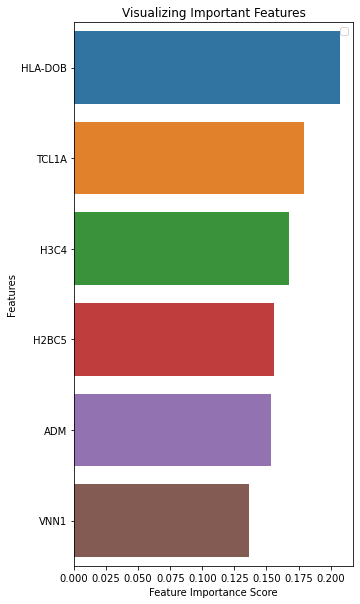

In [55]:
#print(pred_y_rf_new)
importance=rf_new.feature_importances_
#print(importance)
#print(gene)
indices = np.argsort(importance)
#print(indices)

# 输出排序
print("Feature ranking:")
featurerank=[]
im_value=[]
for f in range(exp.shape[1]):
    featurerank.append(gene_all[indices[f]])
    im_value.append(importance[indices[f]])
    print("%d. feature %s (%f)" % (f + 1, gene_all[indices[f]], importance[indices[f]]))
#特征重要性可视化
plt.figure(figsize=(5,10))
feature_imp = pd.Series(im_value,index=featurerank).sort_values(ascending=False)
sns.barplot(x= feature_imp,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [57]:
data = { 'gene' : featurerank, 'importance' :im_value }
df = pd.DataFrame(data)
df.tail()
#df.iloc[305::]['gene']
df.to_csv('deg_module__inter_importance_all.csv')
df[df['importance']>0]

,gene,importance
0,VNN1,0.136743
1,ADM,0.153549
2,H2BC5,0.155598
3,H3C4,0.167286
4,TCL1A,0.179642
5,HLA-DOB,0.207182
